In [128]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 
from statistics import mean, stdev

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 

# Load UDP Benign and DDoS CIC2023 Flows

In [129]:
# Acquire Data
# Data here has all features
current_path = os.getcwd()

# BENIGN DATA FILES ***************************************
file1='dataset/Benign.csv'
benign = pd.read_csv(file1)
benign = benign[(benign['proto_type'] == 17)]
benign['attack'] = 0

# DDOS-VOLUMETRIC ATTACK ***********************************
file2='dataset/UDPFlood.csv'
udp = pd.read_csv(file2)
udp['attack'] = 1

# DDOS-TRANSPORT PROTOCOL VULNERABILITIES *******************
file3='dataset/UDPFrag.csv'
udp_frag = pd.read_csv(file3)
udp_frag['attack'] = 1

## CONCATE ALL THE RECORDS ************************************
frames = [benign, 
          udp, 
          udp_frag]

data = pd.concat(frames)

In [130]:
# Size of the data
print("Shape of data: ", data.shape)
# Attack wise size
print("Attack and Benign Records: ", data["attack"].value_counts())

Shape of data:  (79144, 34)
Attack and Benign Records:  attack
1    65800
0    13344
Name: count, dtype: int64


In [131]:
udp.shape

(39376, 34)

In [132]:
data.columns

Index(['ts', 'srcip', 'dstip', 'srcport', 'dstport', 'proto_type', 'sbytes',
       'dbytes', 'flow_bytes', 'rate', 'srate', 'drate', 'spkts', 'dpkts',
       'ttl', 'iat', 'max_iat', 'min_iat', 'total_duration',
       'N_IN_Conn_P_Src_IP', 'N_IN_Conn_P_Dst_IP', 'avg_pkt_len', 'state_con',
       'state_int', 'state_rst', 'fin_flag_number', 'syn_flag_number',
       'psh_flag_number', 'ack_flag_number', 'urg_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'attack', 'x'],
      dtype='object')

# Select parameters based on the model i.e. with or without time based features

In [133]:
# Features according to Importance
features =  ['flow_bytes', 'spkts','dpkts','ttl','total_duration','min_iat',
             'N_IN_Conn_P_Src_IP', 'N_IN_Conn_P_Dst_IP', 'avg_pkt_len']
best_features = data[features] 
target_features = data[['attack']]

## Descriptio of the parametes

**(1) N_IN_Conn_P_Src_IP**: number of packets sent from a source ip address (note src_ip_bytes is similar to it)
**(2) N_IN_Conn_P_Dst_IP**: number of incoming packets to a destination ip address
**(3) spkts**: number of packets transmitted by a source in a flow till now
**(4) dpkts**: number of packets transmitted by a destination in a flow till now
**(5) srate**: spkts/duration of flow
**(6) drate**: dpkts/duration of flow
**(7) avg_packet_len**: mean packet length in bytes in either direction of the a flow
**(8) state_con**: if this is a TCP packet and not first packet in the flow, with RESET flag not on
**(9) state_int**: 1, if this is first packet in a UDP flow
**(10) state_rst**: if this is a TCP packet and reset flag is on, this is the thir flag in tcp
**(11-17) Flags of TCP**: FIN, SYN, PUSH, URG, ECE, CWR, ACK

# Split Dataset into X and Y

In [134]:
# Split of  predictors and response variable
X= best_features
y= target_features

# Use StratifiedKFold with K=10

In [135]:
# Create  classifier object.
rf = RandomForestClassifier(n_estimators = 1, n_jobs=2, random_state=0, max_depth=8)  
n_splits = 10
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
accu_stratified = []
conf_matrices = []  # Store confusion matrices
per_class_accuracies = [] 

In [136]:
# Create model with StratifiedKFold   
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    rf.fit(x_train_fold, y_train_fold)
    #accu_stratified.append(rf.score(x_test_fold, y_test_fold))

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test_fold,rf.predict(x_test_fold))
    conf_matrices.append(conf_matrix)
    
    # Compute per-class accuracies
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    per_class_accuracies.append(per_class_accuracy)

# Convert lists to numpy arrays for easier manipulation
conf_matrices = np.array(conf_matrices)
per_class_accuracies = np.array(per_class_accuracies)


/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_73868/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)
/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_73868/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)
/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_73868/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)
/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_73868/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

Accuracy of Attack Records:  [0.99101124 0.9917603  0.97602996 0.96928839 0.98425787 0.99550225
 0.994003   0.98875562 0.99250375 0.98950525]

Median Accuracy of Attack Records: 99.0258241665684 %

Standard Deviation of Attack Records: 0.008436740753768192
Accuracy of Benign Records:  [0.98844985 0.98753799 0.98966565 0.993769   0.9887538  0.9893617
 0.99012158 0.98647416 0.98905775 0.98784195]

Median Accuracy of Benign Records: 98.89057750759879 %

Standard Deviation of Benign Records: 0.001963370560452135


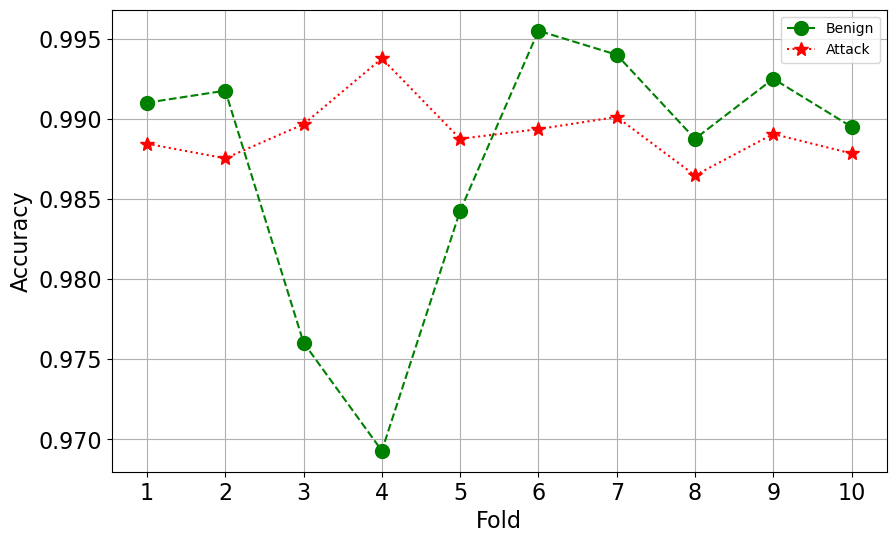

In [137]:
# Plotting per-class accuracies

plt.figure(figsize=(10, 6))
for i, class_accuracy in enumerate(per_class_accuracies.T, 1):
    if(i==1):
        plt.plot(range(1, n_splits + 1), class_accuracy, marker='o', label=f'Benign', color='green',  linestyle='dashed', markersize=10)
        print("Accuracy of Attack Records: ", class_accuracy)
        print('\nMedian Accuracy of Attack Records:', np.median(class_accuracy)*100, '%')
        print('\nStandard Deviation of Attack Records:', stdev(class_accuracy))
    else:
        plt.plot(range(1, n_splits + 1), class_accuracy, marker='*', label=f'Attack', color='red',  linestyle='dotted', markersize=10)  
        print("Accuracy of Benign Records: ", class_accuracy)
        print('\nMedian Accuracy of Benign Records:', np.median(class_accuracy)*100, '%')
        print('\nStandard Deviation of Benign Records:', stdev(class_accuracy))
    
plt.title('')
plt.xlabel('Fold', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(range(1, n_splits + 1))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.legend()
plt.grid(True)
# Save the plot as a PNG file
plt.savefig('StratifiedKFold_5Tree.png', bbox_inches='tight')
plt.show()

# Training model on the whole dataset

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
rf = RandomForestClassifier(n_estimators = 1, n_jobs=2, random_state=0, max_depth=8)
rf.fit(X, y)

/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_73868/4076330508.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


RandomForestClassifier(max_depth=8, n_estimators=1, n_jobs=2, random_state=0)

# Mean Decrease of Accuracy of the Parameters

[0.31105737134222494, 0.02789146599293627, 0.0011959111395898406, 0.01107020862034864, 0.5908554228336896, 0.0, 0.018557148680936015, 0.030548731695405038, 0.008823739694869567]


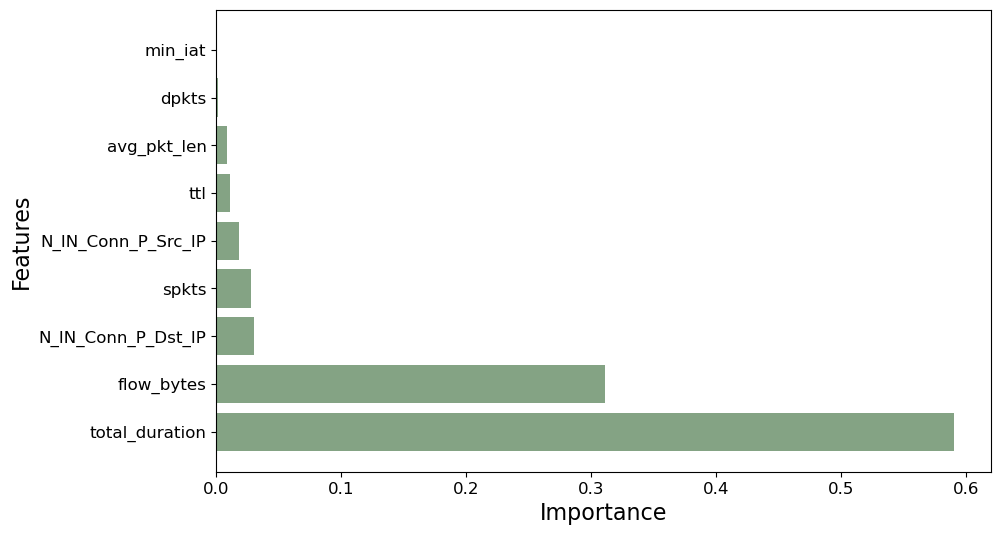

In [139]:
best_features.rename(columns={"N_IN_Conn_P_Src_IP": "N_IN_Conn_Src_IP", "N_IN_Conn_P_Dst_IP": "N_IN_Conn_Dst_IP"})
labels = best_features.columns

importances = list(rf.feature_importances_)
print(importances)
colors = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 
# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_list =[importances[i] for i in sorted_indices]
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('')
plt.barh(range(X.shape[1]), sorted_list, align="center",color=colors )
plt.yticks(range(X.shape[1]), labels[sorted_indices], fontsize=12)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
# Save the plot as a PNG file
plt.savefig('Importance.png', bbox_inches='tight')
plt.show()

# Generate Tree

In [140]:
from sklearn import tree
from sklearn.tree import export_text
i_tree = 0
for tree_in_forest in rf.estimators_:
    with open('tree_' + str(i_tree) + '.dot', 'w') as my_file:
        my_file = tree.export_graphviz(tree_in_forest, out_file = my_file)
        r = export_text(tree_in_forest)
        print("TREE ", i_tree)
        print(r)  
    i_tree = i_tree + 1

TREE  0
|--- feature_4 <= 3.69
|   |--- feature_0 <= 1198.00
|   |   |--- feature_7 <= 28.50
|   |   |   |--- feature_1 <= 4.50
|   |   |   |   |--- feature_6 <= 1.50
|   |   |   |   |   |--- feature_3 <= 56.50
|   |   |   |   |   |   |--- feature_3 <= 19.50
|   |   |   |   |   |   |   |--- feature_0 <= 304.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- feature_0 >  304.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- feature_3 >  19.50
|   |   |   |   |   |   |   |--- feature_7 <= 1.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- feature_7 >  1.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- feature_3 >  56.50
|   |   |   |   |   |   |--- feature_8 <= 331.50
|   |   |   |   |   |   |   |--- feature_4 <= 0.19
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- feature_4 >  0.19
|   |   |   |   |   |   |   |   |--- class: 1.0
| 

# Save the RF Attack Detector

In [141]:
import pickle as pickle
filename = 'final_rf_model_dos_udp.sav'
pickle.dump(rf, open(filename, 'wb'))

# Display (Match-Action) Rules of the RF Tree, acceptable to P4

In [142]:
from io import StringIO
from numbers import Integral

import numpy as np
import pandas
import pickle 
import sklearn
from sklearn import tree 
from sklearn.tree import export_text

from sklearn.tree import _tree

from sklearn.tree import DecisionTreeClassifier

filename = 'final_rf_model_dos_udp.sav'
rf = pickle.load(open(filename, 'rb'))

i_tree = 0 

global_id = 0

def export_p4(decision_tree):
    tree_ = decision_tree.tree_
    class_names = decision_tree.classes_
    right_child_fmt = "{} {} <= {}\n"
    left_child_fmt = "{} {} >  {}\n"
    truncation_fmt = "{} {}\n"
    feature_names_ = ["{}".format(i) for i in tree_.feature]  
    export_text.report = ""
    max_depth=10
    spacing=3
    decimals=2
    show_weights=False

    if isinstance(decision_tree, DecisionTreeClassifier):
        value_fmt = "{}{} weights: {}\n"
        if not show_weights:
            value_fmt = "{}{}{}\n"
    else:
        value_fmt = "{}{} value: {}\n"

    def _add_leaf(value, class_name, indent, prevfeature, result, depth, previous_id):
        global global_id
        global i_tree 
        current_id = global_id

        val = ''
        is_classification = isinstance(decision_tree,
                                       DecisionTreeClassifier)
        if show_weights or not is_classification:
            val = ["{1:.{0}f}, ".format(decimals, v) for v in value]
            val = '['+''.join(val)[:-2]+']'
        if is_classification:
            val += ' class: ' + str(class_name)
        export_text.report += value_fmt.format(indent, '', val)
        #print("table_add MyIngress.level_", i_tree,"_", depth, " ", "MyIngress.SetClass",i_tree," ", previous_id," ",prevfeature," ", result," ", "=>"," ", current_id, " ", int(float(class_name)), sep="")
        print("table_add MyIngress.UDPlevel_", depth, " ", "MyIngress.SetClassUDP"," ", previous_id," ",prevfeature," ", result," ", "=>"," ", current_id, " ", int(float(class_name)), sep="")

    def print_tree_recurse(node, depth, prevfeature, result, previous_id):
        indent = ("|" + (" " * spacing)) * depth
        indent = indent[:-spacing] + "-" * spacing
        global global_id
        global i_tree 
        global_id = global_id + 1
        current_id = global_id

        value = None
        if tree_.n_outputs == 1:
            value = tree_.value[node][0]
        else:
            value = tree_.value[node].T[0]
        class_name = np.argmax(value)

        if (tree_.n_classes[0] != 1 and
                tree_.n_outputs == 1):
            class_name = class_names[class_name]

        if depth <= max_depth+1:
            info_fmt = ""
            info_fmt_left = info_fmt
            info_fmt_right = info_fmt

            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_names_[node]
                threshold = tree_.threshold[node]
                threshold = "{1:.{0}f}".format(decimals, threshold)
                export_text.report += right_child_fmt.format(indent,
                                                             name,
                                                             threshold)
                export_text.report += info_fmt_left
                #print("table_add MyIngress.level_", i_tree,"_", depth, " MyIngress.CheckFeature ", previous_id, " ", prevfeature, " ", result, " ", "=>", " ", current_id, " ", name," ", int(float(threshold)), sep='')
                print("table_add MyIngress.UDPlevel_", depth, " MyIngress.CheckFeatureUDP ", previous_id, " ", prevfeature, " ", result, " ", "=>", " ", current_id, " ", name," ", int(float(threshold)), sep='')

                
                print_tree_recurse(tree_.children_left[node], depth+1, name, 1, current_id)

                export_text.report += left_child_fmt.format(indent,
                                                            name,
                                                            threshold)
                export_text.report += info_fmt_right
           #     print("level", depth, "checkfeature", prevfeature, result, "=>", name, threshold)
 

                print_tree_recurse(tree_.children_right[node], depth+1, name, 0, current_id)
            else:  # leaf
                _add_leaf(value, class_name, indent, prevfeature, result, depth, previous_id)
        else:
            subtree_depth = _compute_depth(tree_, node)
            if subtree_depth == 1:
                _add_leaf(value, class_name, indent, prevfeature, result, depth, previous_id)
            else:
                trunc_report = 'truncated branch of depth %d' % subtree_depth
                export_text.report += truncation_fmt.format(indent,
                                                            trunc_report)

    print_tree_recurse(0, 1, 0, 1, global_id)


for tree_in_forest in rf.estimators_:
  #r = export_text(tree_in_forest)
  #print(r)
  global i_tree

  i_tree = i_tree + 1
  export_p4(tree_in_forest)

table_add MyIngress.UDPlevel_1 MyIngress.CheckFeatureUDP 0 0 1 => 1 4 3
table_add MyIngress.UDPlevel_2 MyIngress.CheckFeatureUDP 1 4 1 => 2 0 1198
table_add MyIngress.UDPlevel_3 MyIngress.CheckFeatureUDP 2 0 1 => 3 7 28
table_add MyIngress.UDPlevel_4 MyIngress.CheckFeatureUDP 3 7 1 => 4 1 4
table_add MyIngress.UDPlevel_5 MyIngress.CheckFeatureUDP 4 1 1 => 5 6 1
table_add MyIngress.UDPlevel_6 MyIngress.CheckFeatureUDP 5 6 1 => 6 3 56
table_add MyIngress.UDPlevel_7 MyIngress.CheckFeatureUDP 6 3 1 => 7 3 19
table_add MyIngress.UDPlevel_8 MyIngress.CheckFeatureUDP 7 3 1 => 8 0 304
table_add MyIngress.UDPlevel_9 MyIngress.SetClassUDP 8 0 1 => 9 0
table_add MyIngress.UDPlevel_9 MyIngress.SetClassUDP 8 0 0 => 10 0
table_add MyIngress.UDPlevel_8 MyIngress.CheckFeatureUDP 7 3 0 => 11 7 1
table_add MyIngress.UDPlevel_9 MyIngress.SetClassUDP 11 7 1 => 12 1
table_add MyIngress.UDPlevel_9 MyIngress.SetClassUDP 11 7 0 => 13 1
table_add MyIngress.UDPlevel_7 MyIngress.CheckFeatureUDP 6 3 0 => 14 8 331

# Now predicting about separatly processes data

In [143]:
current_path = os.getcwd()

file1='dataset/Benign_Test_1.csv'
benign = pd.read_csv(file1)
benign = benign[(benign['proto_type'] == 17)]

file2='dataset/UDPFlood_Test_2.csv'
udp = pd.read_csv(file2)
file3='dataset/UDPFrag_Test.csv'
udp_frag = pd.read_csv(file3)

benign['attack'] = 0
udp['attack'] = 1
udp_frag['attack'] = 1

In [144]:
data = pd.concat([benign])
print(data.columns)

Index(['ts', 'srcip', 'dstip', 'srcport', 'dstport', 'proto_type', 'sbytes',
       'dbytes', 'flow_bytes', 'rate', 'srate', 'drate', 'spkts', 'dpkts',
       'ttl', 'iat', 'max_iat', 'min_iat', 'total_duration',
       'N_IN_Conn_P_Src_IP', 'N_IN_Conn_P_Dst_IP', 'avg_pkt_len', 'state_con',
       'state_int', 'state_rst', 'fin_flag_number', 'syn_flag_number',
       'psh_flag_number', 'ack_flag_number', 'urg_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'attack'],
      dtype='object')


In [145]:
benign['sbytes'].head(10)

31      214
53      230
61      218
92      230
95      336
97      300
98      609
99      999
100    1389
101     388
Name: sbytes, dtype: int64

# Test Benign

In [146]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

data = pd.concat([benign])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:", 1- sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.9407407407407408
Precision:  [1. 0.]
Recall:  [0.94074074 0.        ]
F1-score:  [0.96946565 0.        ]
Support:  [135   0]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test UDP Flood

In [147]:
data = pd.concat([udp])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:",  sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.9963285910968334
Precision:  [0. 1.]
Recall:  [0.         0.99632859]
F1-score:  [0.         0.99816092]
Support:  [    0 13074]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test UDP Frag

In [148]:
data = pd.concat([udp_frag])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:",  sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.9961977186311787
Precision:  [0. 1.]
Recall:  [0.         0.99619772]
F1-score:  [0.         0.99809524]
Support:  [  0 526]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
